In [311]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# preprocesssing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.inspection import permutation_importance


# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 20240417
PATH_TO_FILE = './DT_titanic.csv'

In [312]:
df = pd.read_csv(PATH_TO_FILE)

In [313]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin has only 204 out of 991 non-null values - the column is informative, 
we can drop it

In [317]:
df[df['Survived'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [318]:
df.drop(columns='Cabin', inplace=True)

PassengerId, ticket number and Name are irrelevant for prediction
we can drop them too

In [319]:
df.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)

In [320]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [321]:
# split into cat and num features
target_feature = 'Survived'

cat_features = [col for col in df.columns if col not in [target_feature, 'Name'] and pd.api.types.is_object_dtype(df[col])]
num_features = [col for col in df.columns if col not in [target_feature, 'Name']+cat_features]

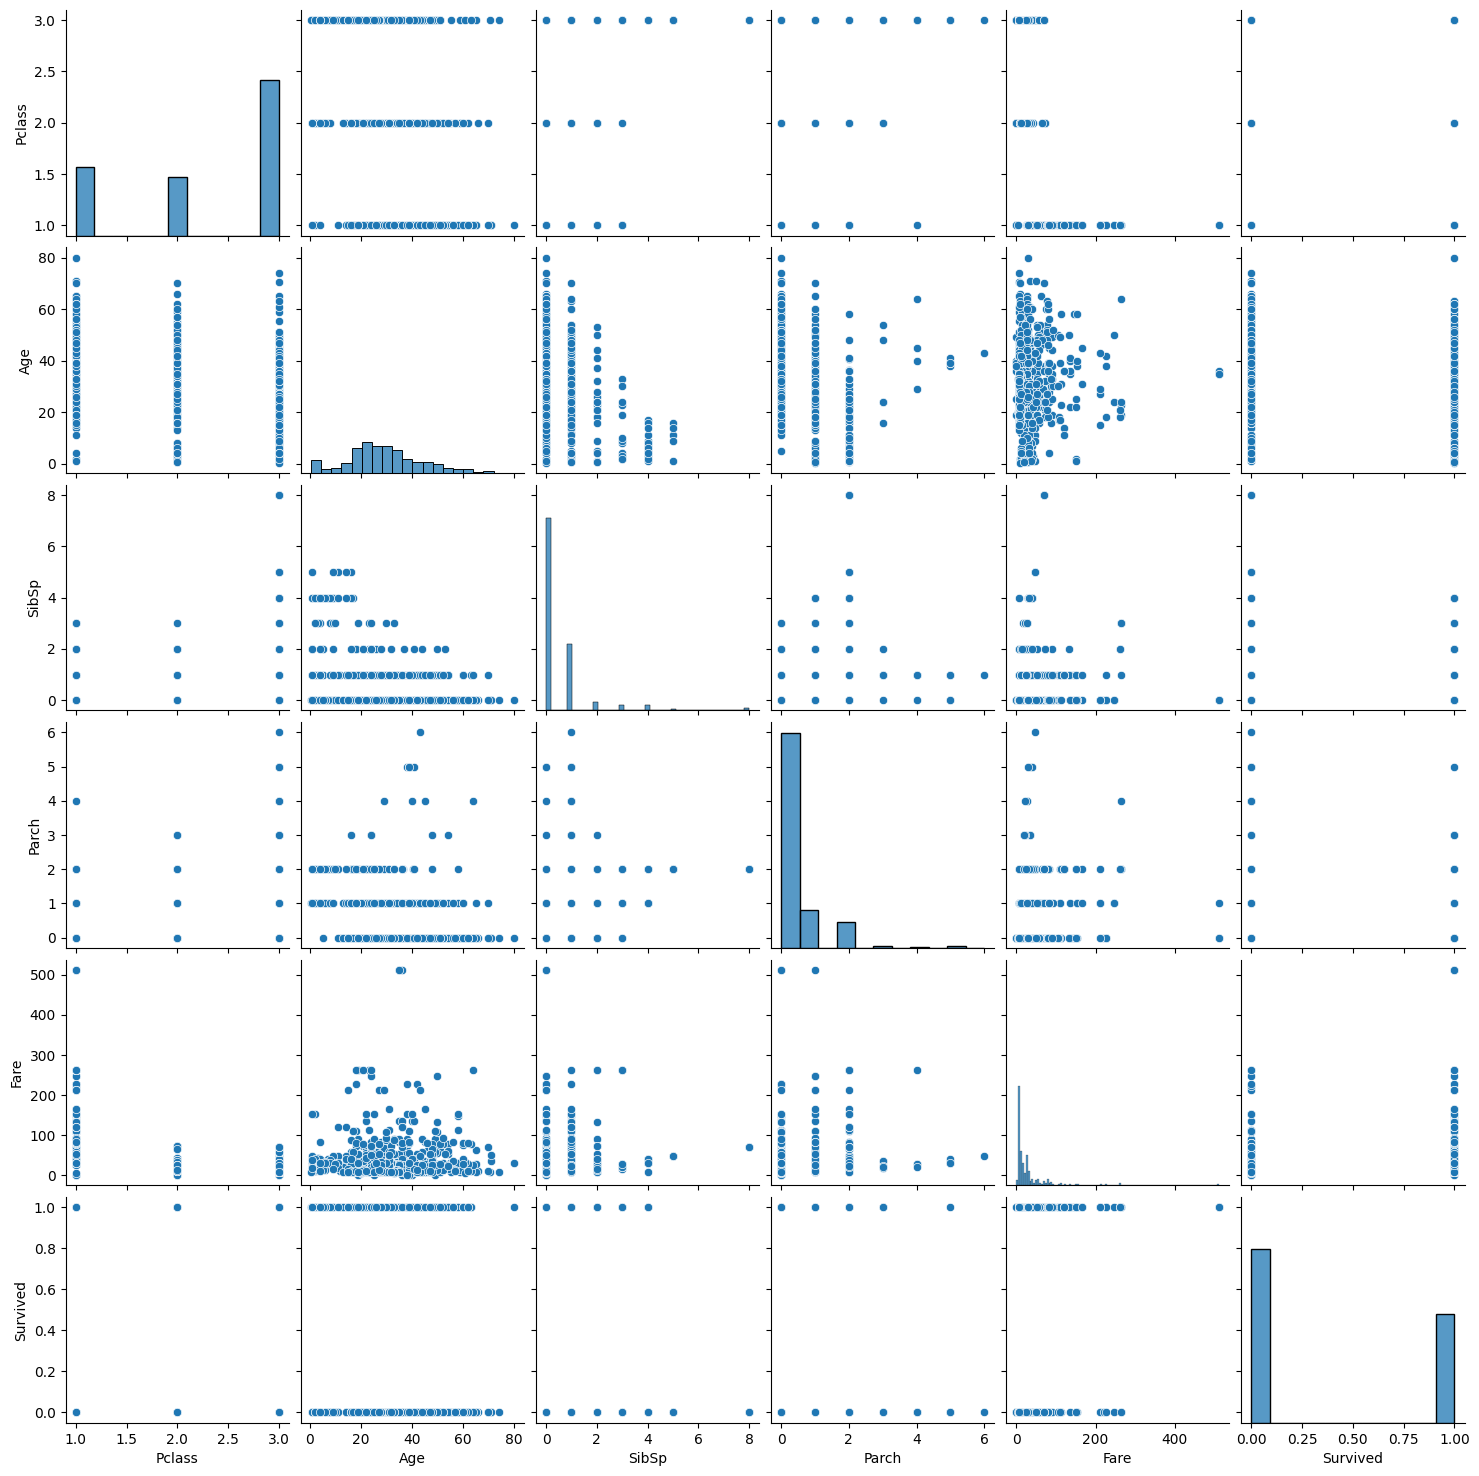

In [322]:
sns.pairplot(df[num_features + ['Survived']])

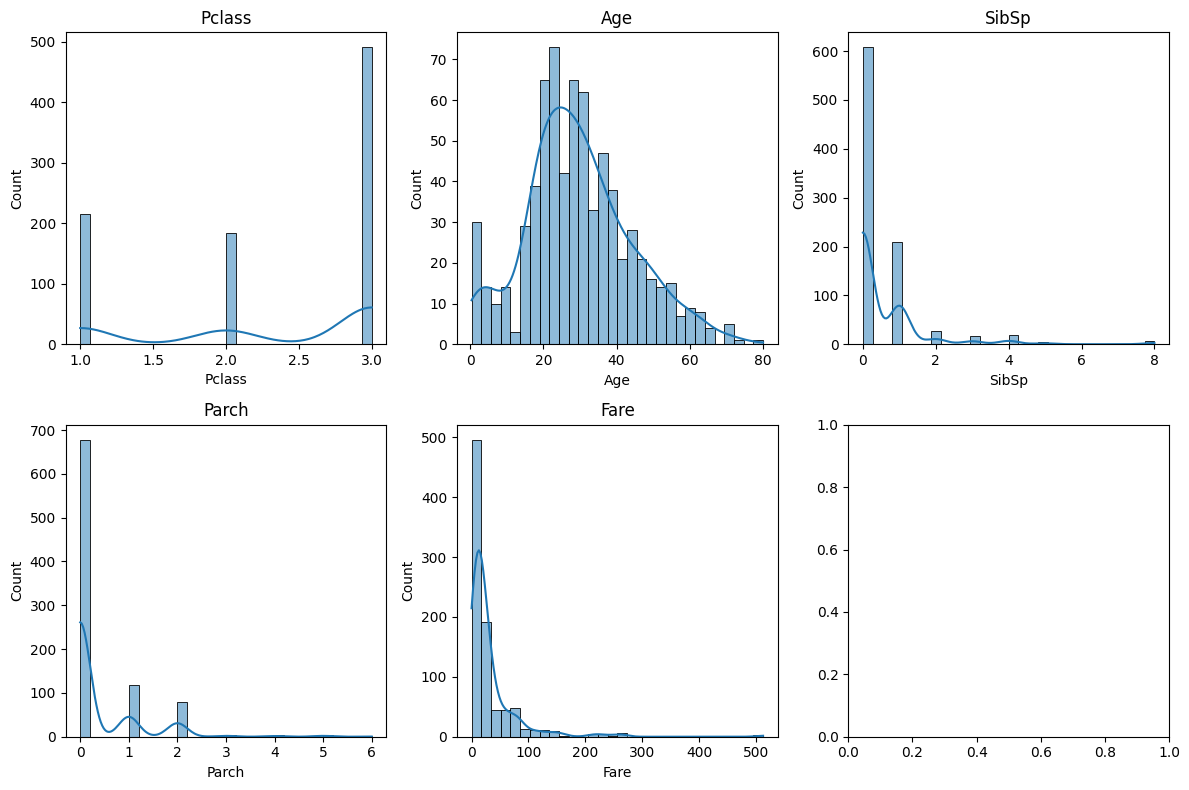

In [323]:
nrows = int(np.ceil(len(num_features) / 3))
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for idx, feature in enumerate(num_features):
    axs[idx//ncols, idx%ncols].set_title(feature)
    sns.histplot(df[feature], kde=True, ax=axs[idx//ncols, idx%ncols], bins=30)
plt.tight_layout()
plt.show()

---
## Understanding the data

In [324]:
df['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [325]:
print(f"Parch > 2 is {df[df['Parch'] > 2]['Parch'].count() / df.size * 100:.2f}%")
print(df[df['Parch'] > 2]['Parch'].count())
#  we can drop them

Parch > 2 is 0.21%
15


In [326]:
parch_indeces = np.array(df.index)[np.argsort(df['Parch'].values)][-15:]
df.drop(index=parch_indeces, inplace=True) # ['Parch'].value_counts()

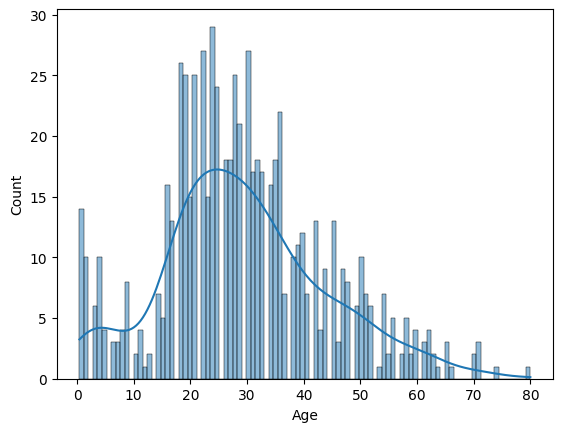

In [327]:
sns.histplot(df['Age'], kde=True, bins=100)
plt.show()

In [328]:
pd.DataFrame(df['Age'].value_counts()).sort_values(by='count')

,count
Age,
74.00,1
20.50,1
14.50,1
34.50,1
0.42,1
...,...
28.00,25
19.00,25
18.00,26


In [330]:
# lets_convert sex into numeric type
sex_encoder = LabelEncoder()
sex = sex_encoder.fit_transform(df["Sex"].values)
print(df["Sex"].iloc[:5].values, sex[:5])
df["Sex"] = sex

['male' 'female' 'female' 'female' 'male'] [1 0 0 0 1]


In [331]:
# embarked has some data gaps, let's feel it with the most common
top_embarked = pd.DataFrame(df['Embarked'].describe()).loc['top']
embarked = df['Embarked'].values
df['Embarked'] = np.where(pd.isna(embarked), top_embarked, embarked)

In [337]:
df[df['Survived'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [345]:
len(df[num_features])

876

In [338]:
# lets incode embarked into one hot encoded vector
onehot_encoder = OneHotEncoder()
encoded_feature = onehot_encoder.fit_transform(df['Embarked'].values.reshape(-1, 1))
encoded_feature_names = onehot_encoder.get_feature_names_out(["Embarked"])
print(encoded_feature_names)
print(df["Embarked"].iloc[0], encoded_feature.toarray()[0])
print(df["Embarked"].iloc[1], encoded_feature.toarray()[1])
print(df["Embarked"].iloc[2], encoded_feature.toarray()[2])

['Embarked_C' 'Embarked_Q' 'Embarked_S']
S [0. 0. 1.]
C [1. 0. 0.]
S [0. 0. 1.]


In [346]:
encoded_df = pd.DataFrame(encoded_feature.toarray(),index=df.index, columns=encoded_feature_names, dtype=int)
encoded_df = pd.concat([df[num_features], encoded_df], axis=1)
encoded_df['Sex'] = df["Sex"]
encoded_df[target_feature] = df[target_feature]
encoded_df.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived
0,3,22.0,1,0,7.2500,0,0,1,1,0
1,1,38.0,1,0,71.2833,1,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,1
4,3,35.0,0,0,8.0500,0,0,1,1,0


In [347]:
len(encoded_df)

876

In [348]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      876 non-null    int64  
 1   Age         699 non-null    float64
 2   SibSp       876 non-null    int64  
 3   Parch       876 non-null    int64  
 4   Fare        876 non-null    float64
 5   Embarked_C  876 non-null    int64  
 6   Embarked_Q  876 non-null    int64  
 7   Embarked_S  876 non-null    int64  
 8   Sex         876 non-null    int64  
 9   Survived    876 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 107.6 KB


In [349]:
encoded_df[encoded_df['Survived'].isna()]

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived


In [350]:
df = encoded_df

In [351]:
df['Sex'][df["Age"].isna()].count()

177

In [352]:
# lets fill in the gaps of age
median = df[~df["Age"].isna()]["Age"].median()
print(f"median = {median}")

vals = df["Age"].values
filled_vec = np.where(np.isnan(vals), median, vals)

df["Age"] = filled_vec

median = 28.0


In [353]:
print(f"between 0 and 10 years: {df[(df['Age'] > 0) & (df['Age'] <= 10)]['Age'].count()}")
print(f"between 10 and 20 years: {df[(df['Age'] > 10) & (df['Age'] <= 20)]['Age'].count()}")
print(f"between 20 and 30 years: {df[(df['Age'] > 20) & (df['Age'] <= 30)]['Age'].count()}")
print(f"between 30 and 40 years: {df[(df['Age'] > 30) & (df['Age'] <= 40)]['Age'].count()}")
print(f"between 40 and 70 years: {df[(df['Age'] > 40) & (df['Age'] < 70)]['Age'].count()}")
print(f"more than 70 years: {df[df['Age'] >= 70]['Age'].count()}")

between 0 and 10 years: 64
between 10 and 20 years: 114
between 20 and 30 years: 404
between 30 and 40 years: 150
between 40 and 70 years: 137
more than 70 years: 7


In [354]:
# let's drop people with age more than 70
age_indeces = np.array(df.index)[np.argsort(df["Age"].values)][-7:]
df.drop(index=age_indeces, inplace=True)

In [355]:
df[df["Age"] >= 70]

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived


In [356]:
features = [col for col in df.columns if col != target_feature]

In [357]:
X, y = df[features].values, df[target_feature].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [358]:
dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [362]:
np.where(dt.predict(X_test) == y_test, 1, 0).sum() / len(y_test) * 100

78.73563218390804